# Semester 3 Coding Portfolio Topic 5 Formative Part 2/2:
# Social networks 2: Complex and dynamical networks using Python and networkx

This notebook covers the following topics:
 - Simulation with networks

This notebook is expected to take around 5 hours to complete:
 - 2 hours for the formative part
 - 3 hours of self-study on the topics covered by this notebook

Like all topics in this portfolio, this topic is split into two sections:
 - Formative 
 - Summative

<b>Formative section</b><br>
Simply complete the given functions such that they pass the automated tests. This part is graded Pass/Fail; you must get 100% correct!
You can submit your notebook through Canvas as often as you like. Make sure to start doing so early to insure that your code passes all tests!
You may ask for help from fellow students and TAs on this section, and solutions might be provided later on.

In this workshop, we will focus on generating networks through code, and seeing some of the interesting and at times unexpected dynamics of networks.

We will learn how to generate network using algorithms, and how the algorithms shape the properties of these networks


In [1]:
# Install all necessary packages first to avoid kernel restarts
# This ensures all dependencies are available before running the notebook
import sys
import subprocess

# List of required packages for this notebook
required_packages = [
    'numpy',
    'networkx',
    'matplotlib',
    'scipy'
]

# Install packages that are not already installed
for package in required_packages:
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed successfully")

print("\nAll packages are ready! You can now run the notebook without restarting the kernel.")


✓ numpy is already installed
✓ networkx is already installed
✓ matplotlib is already installed
✓ scipy is already installed

All packages are ready! You can now run the notebook without restarting the kernel.


In [2]:
# Imports. Make sure your solution does not import any third-party modules not imported here!
import random
import itertools
from collections import Counter
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import scipy.stats as stats

# 1. Small world simulation

In this exercise, we will start with a geographical network, in which each node is connected to their four closest neighbhors, in a big circle.

We will then see how the average shortest path depends on the number of edges we randomize in this network.

The aim of this exercise is to see how nearly universal the small-world phenomenon is. 

In [3]:
# Circle network
def create_circle_network(num_nodes=1000):
    # This is code creates a simple circular network, were each node is connected to their neighbors 
    # Create an empty graph
    G = nx.Graph()
    
    # Add nodes and edges to create a circular network
    for i in range(num_nodes):
        G.add_node(i)
        G.add_edge(i, (i + 1) % num_nodes)  # Connect each node to its neighbor, using modulo for circular connection
        G.add_edge(i, (i + 2) % num_nodes)  # Connect each node to its second neighbor, using modulo for circular connection
    
    # Draw the network
    nx.draw_circular(G, with_labels=True, node_color='lightblue', node_size=20, font_size=5)
    plt.title(f"Random Network with {num_nodes} Nodes")
    plt.show()
    return G

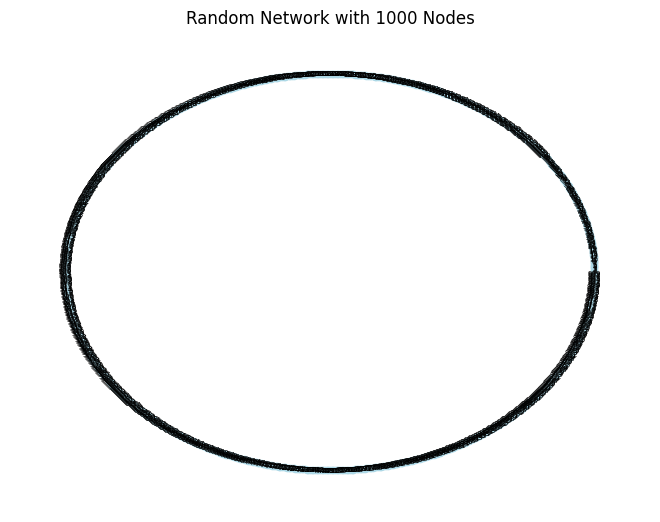

The average shortest path between two nodes in this network is 125.37537537537537


In [4]:
G = create_circle_network()
print(f'The average shortest path between two nodes in this network is {nx.average_shortest_path_length(G)}')

### Exercise 1:
Your task is to answer: *What fraction of edges would you need to replace with random edges for the average shortest path to drop to 1/10 of this value* (i.e. 12.5)? Write code to replace the edges one by one by a random edge. For each edge removed, measure the new average shortest path. Plot the average shortest path as a function of the fraction of edges that are randomized. How do you interpret your finding? 


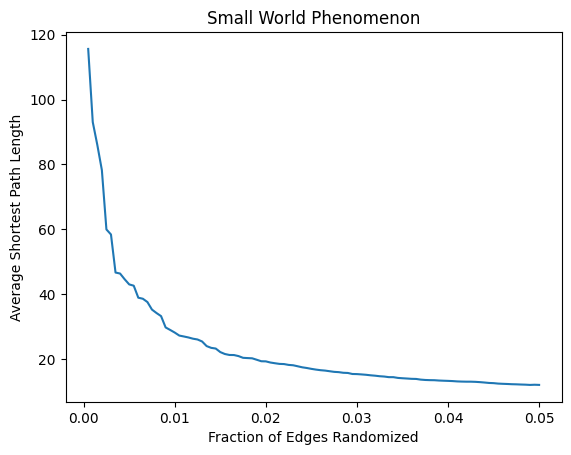

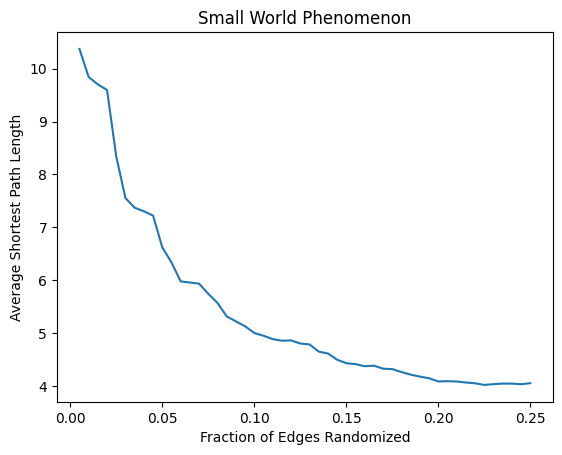

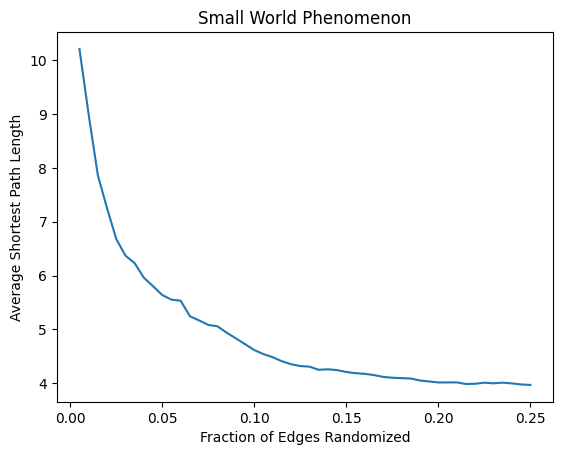

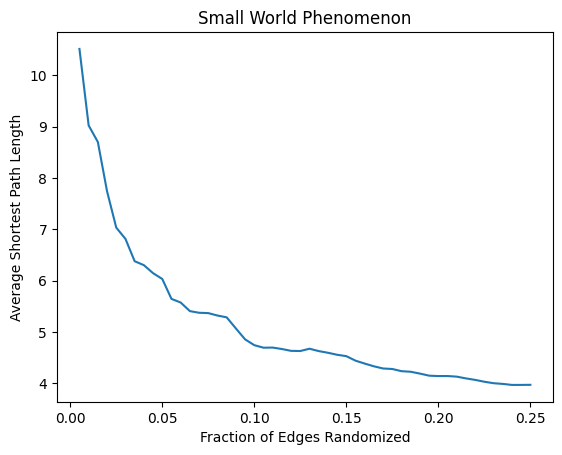

In [5]:
def simulate_small_world_randomization(num_nodes=1000, max_iterations=100, target_path_length=12.5):
    """Simulate small world phenomenon by randomizing edges in a circle network.
    
    Args:
        num_nodes: Number of nodes in the network
        max_iterations: Maximum number of edges to randomize
        target_path_length: Target average shortest path length to achieve
        
    Returns:
        tuple: (fractions, lengths, threshold_fraction) where fractions is list of edge 
               fraction randomized, lengths is list of average path lengths, and 
               threshold_fraction is when target was reached
    """
    # Step 1: Create the initial circle network (each node connected to 4 nearest neighbors)
    # This creates a regular network structure where nodes are arranged in a circle
    G = nx.Graph()
    
    # Add all nodes to the graph
    for i in range(num_nodes):
        G.add_node(i)
    
    # Connect each node to its 4 nearest neighbors (2 on each side)
    # This creates a regular lattice structure in a circular arrangement
    for i in range(num_nodes):
        # Connect to immediate neighbor (i+1 mod num_nodes wraps around)
        G.add_edge(i, (i + 1) % num_nodes)
        # Connect to second neighbor (i+2 mod num_nodes)
        G.add_edge(i, (i + 2) % num_nodes)
    
    # Calculate total number of edges in the initial network
    total_edges = G.number_of_edges()
    
    # Step 2: Initialize lists to track our measurements
    fractions = []  # Will store the fraction of edges that have been randomized
    lengths = []    # Will store the average shortest path length at each step
    threshold_fraction = None  # Will store the fraction when target path length is reached
    
    # Step 3: Iteratively randomize edges and measure the effect
    for iteration in range(max_iterations):
        # Get all current edges as a list (we need to convert to list to sample from it)
        edges_list = list(G.edges())
        
        # If no edges remain, break (shouldn't happen, but safety check)
        if len(edges_list) == 0:
            break
        
        # Randomly select an edge to remove
        # This edge represents a local connection in our circle network
        edge_to_remove = random.choice(edges_list)
        node1, node2 = edge_to_remove
        
        # Remove the selected edge from the network
        # This breaks a local connection
        G.remove_edge(node1, node2)
        
        # Step 4: Add a new random edge to replace the removed one
        # This creates a "long-range" connection that can dramatically reduce path lengths
        # We need to ensure we don't create self-loops or duplicate edges
        all_nodes = list(G.nodes())
        
        # Find two random nodes that are not already connected
        # Keep trying until we find a valid pair
        attempts = 0
        while attempts < 100:  # Safety limit to avoid infinite loops
            new_node1 = random.choice(all_nodes)
            new_node2 = random.choice(all_nodes)
            
            # Check if this is a valid new edge:
            # - Nodes must be different (no self-loops)
            # - Edge must not already exist
            if new_node1 != new_node2 and not G.has_edge(new_node1, new_node2):
                G.add_edge(new_node1, new_node2)
                break
            attempts += 1
        
        # Step 5: Calculate the average shortest path length after this randomization
        # This measures how "small" the world has become (how many steps on average to reach any node)
        # Note: This can be computationally expensive for large networks
        if nx.is_connected(G):  # Only calculate if network is still connected
            avg_path_length = nx.average_shortest_path_length(G)
        else:
            # If network is disconnected, we can't calculate average path length
            # In this case, we'll use a large value or skip this iteration
            avg_path_length = float('inf')
        
        # Step 6: Calculate what fraction of edges have been randomized so far
        # We divide by total_edges to get a fraction between 0 and 1
        fraction_randomized = (iteration + 1) / total_edges
        
        # Store our measurements
        fractions.append(fraction_randomized)
        lengths.append(avg_path_length)
        
        # Step 7: Check if we've reached the target path length
        # This is the "small world" threshold - when path length drops significantly
        if threshold_fraction is None and avg_path_length <= target_path_length:
            threshold_fraction = fraction_randomized
    
    
    plt.plot(fractions, lengths)
    plt.xlabel('Fraction of Edges Randomized')
    plt.ylabel('Average Shortest Path Length')
    plt.title('Small World Phenomenon')
    plt.show()
    
    return fractions, lengths, threshold_fraction

fractions, lengths, threshold_fraction = simulate_small_world_randomization()

# BEGIN TESTS
# @name("Simulation Structure")
# @description("Check that the simulation returns correct data structures")
def test_simulation_structure():
    test_fractions, test_lengths, test_threshold = simulate_small_world_randomization(num_nodes=100, max_iterations=50, target_path_length=5.0)
    assert isinstance(test_fractions, list), "fractions should be a list"
    assert isinstance(test_lengths, list), "lengths should be a list"
    assert len(test_fractions) == len(test_lengths), "fractions and lengths should have same length"
    assert len(test_fractions) == 50, "Should have exactly 50 iterations"
test_simulation_structure()

# @name("Path Length Reduction")
# @description("Check that average path length decreases as edges are randomized")
def test_path_length_reduction():
    test_fractions, test_lengths, test_threshold = simulate_small_world_randomization(num_nodes=100, max_iterations=50, target_path_length=5.0)
    # Path length should generally decrease
    assert test_lengths[-1] < test_lengths[0], "Average path length should decrease after randomization"
test_path_length_reduction()

# @name("Threshold Detection")
# @description("Check that threshold fraction is correctly detected")
def test_threshold_detection():
    test_fractions, test_lengths, test_threshold = simulate_small_world_randomization(num_nodes=100, max_iterations=50, target_path_length=5.0)
    if test_threshold is not None:
        assert 0 <= test_threshold <= 1, "Threshold fraction should be between 0 and 1"
        threshold_idx = test_fractions.index(test_threshold)
        assert test_lengths[threshold_idx] < 5.0, "Path length at threshold should be below target"
test_threshold_detection()
# END TESTS

# 2. Modeling how we make friends

Let's think about different models for how we make friends, and examine the type of social network that this results in.

### Model 1: We meet random people
One is just by meeting people by random. This would suggest just adding edges between two randomly selected nodes until we have as many edges that we want.

This is called an Erdos-Renyi network.

#### Exercise 2A: 
1. Write code for a network in which the nodes are connected to other nodes by random.
2. Plot the degree distribution. You have come across this distribution before. What type of distribution is it? 

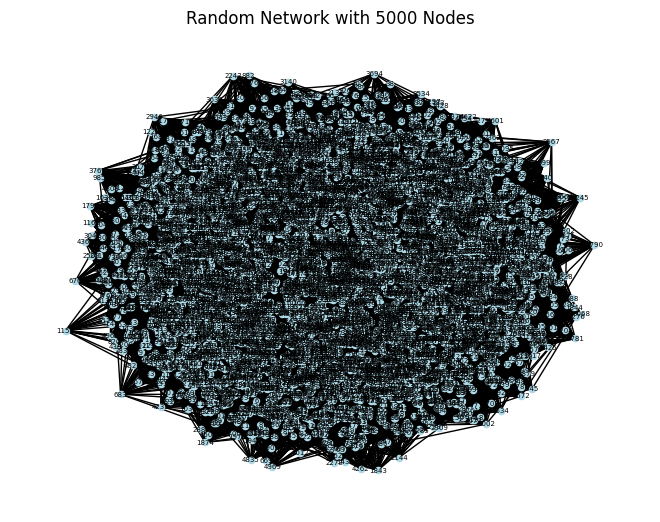

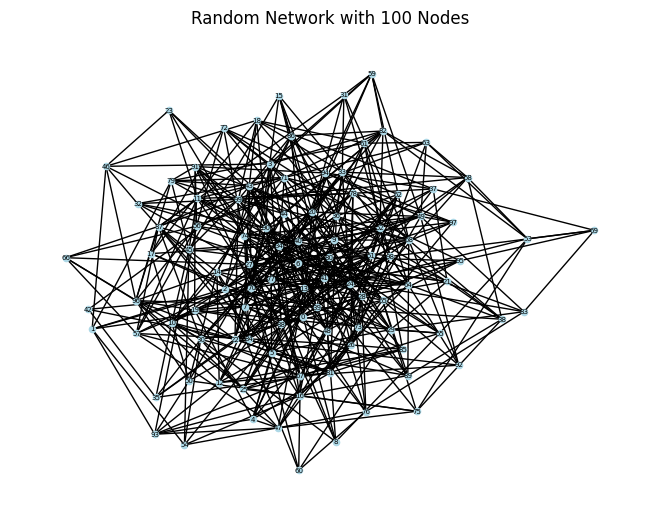

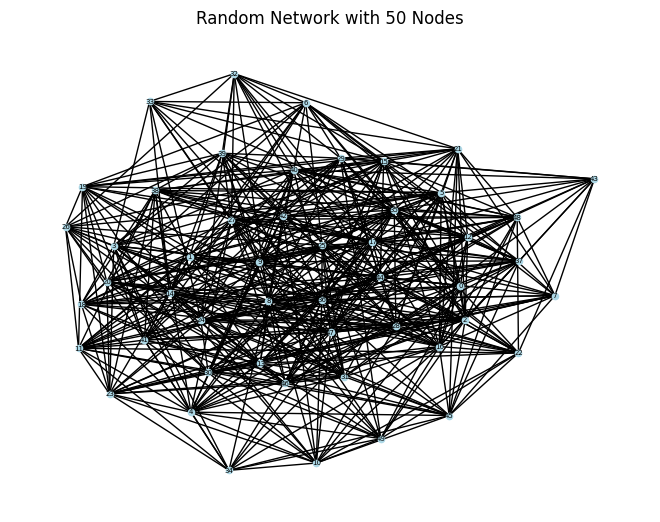

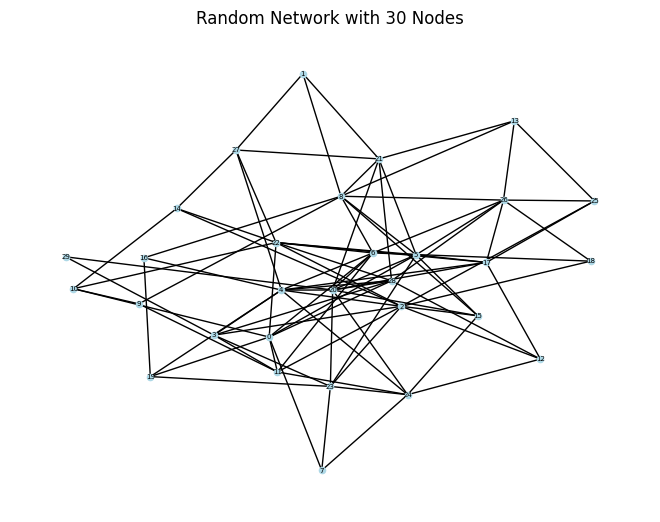

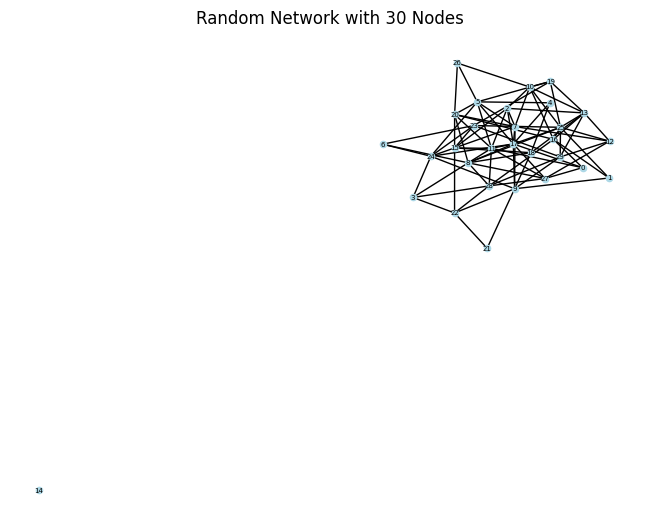

In [6]:
# Random network
def create_random_network(num_nodes, num_edges_per_node):
    """Create a random Erdos-Renyi network.
    
    Args:
        num_nodes: Number of nodes in the network
        num_edges_per_node: Average number of edges per node
        
    Returns:
        NetworkX Graph object
    """
    G = nx.Graph()
    
    # Add the nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Step 3: Calculate total number of edges we want to add
    # If each node should have num_edges_per_node edges on average,
    # then total edges = num_nodes * num_edges_per_node
    total_edges_to_add = num_nodes * num_edges_per_node
    
    # Step 4: Add random edges until we reach the target number
    # We use a while loop because some random pairs might already be connected
    edges_added = 0
    max_attempts = total_edges_to_add * 10  # Safety limit to avoid infinite loops
        
    while edges_added < total_edges_to_add and max_attempts > 0:
        # Randomly select two different nodes
        node1 = random.randint(0, num_nodes - 1)
        node2 = random.randint(0, num_nodes - 1)
        
        # Make sure nodes are different (no self-loops)
        if node1 == node2:
            max_attempts -= 1
            continue
        
        # Check if this edge already exists
        # If not, add it to the graph
        if not G.has_edge(node1, node2):
            G.add_edge(node1, node2)
            edges_added += 1
        
        max_attempts -= 1
    
    # Note: Due to randomness, we might not reach exactly total_edges_to_add
    # if the network becomes very dense, but this is fine for our purposes
    

    # Draw the network
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=20, font_size=5)
    plt.title(f"Random Network with {num_nodes} Nodes")
    plt.show()
    return G

G = create_random_network(5000, 25)

# BEGIN TESTS
# @name("Network Creation")
# @description("Check that the network is created with correct number of nodes")
def test_network_creation():
    test_G = create_random_network(100, 5)
    assert test_G.number_of_nodes() == 100, f"Network should have exactly 100 nodes, but has {test_G.number_of_nodes()}"
    assert isinstance(test_G, nx.Graph), "Should return a NetworkX Graph"
test_network_creation()

# @name("Edge Addition")
# @description("Check that edges are added to the network")
def test_edge_addition():
    test_G = create_random_network(50, 10)
    assert test_G.number_of_edges() > 0, "Network should have edges"
    # Should have approximately num_edges_per_node * num_nodes edges (some may be duplicates)
    assert test_G.number_of_edges() <= 50 * 10, "Should not exceed maximum possible edges added"
test_edge_addition()

# @name("Randomness Check")
# @description("Check that edge generation is random by comparing two networks")
def test_randomness():
    test_G1 = create_random_network(30, 3)
    test_G2 = create_random_network(30, 3)
    edges1 = set(test_G1.edges())
    edges2 = set(test_G2.edges())
    # Networks should not be identical (extremely unlikely with random generation)
    assert edges1 != edges2, "Graph generation is not random; the function generates identical graphs"
test_randomness()
# END TESTS

### Exercise 2B:
Let's plot the degree distribution of this network. To do so, we create a histogram of the frequency of each number of degrees. 

The degree distribution is a highly important measure, as it shows how equal the network is, and how dominated it is by a few nodes.



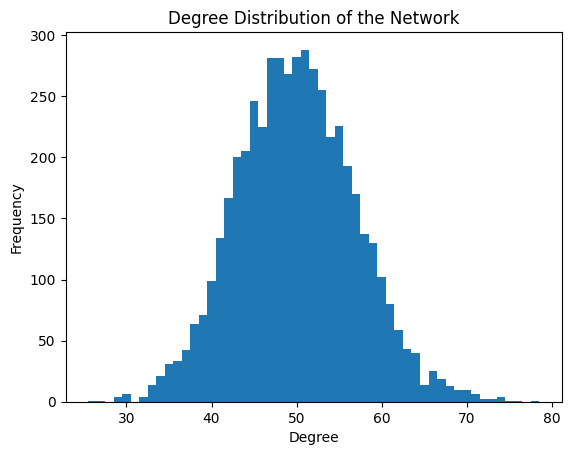

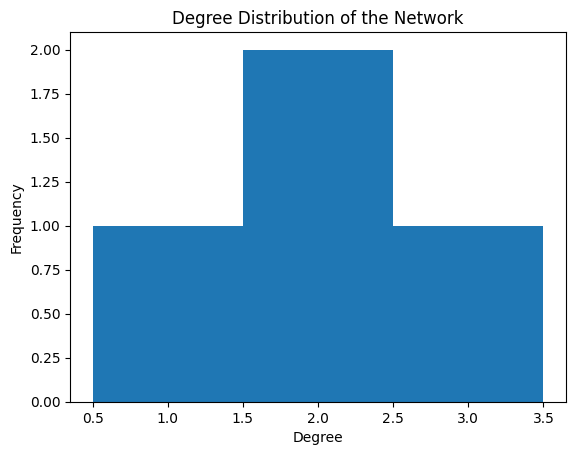

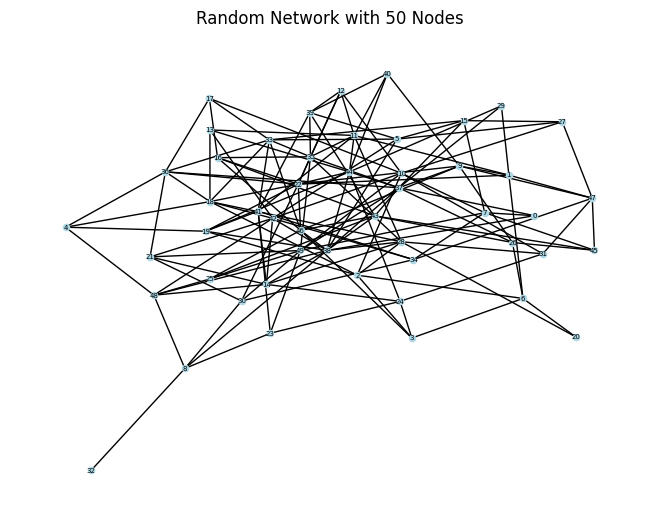

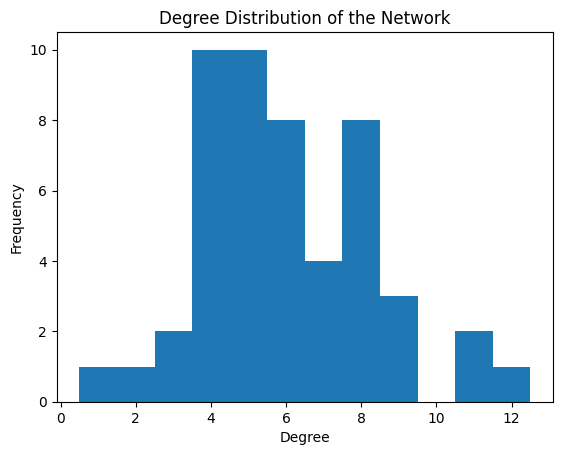

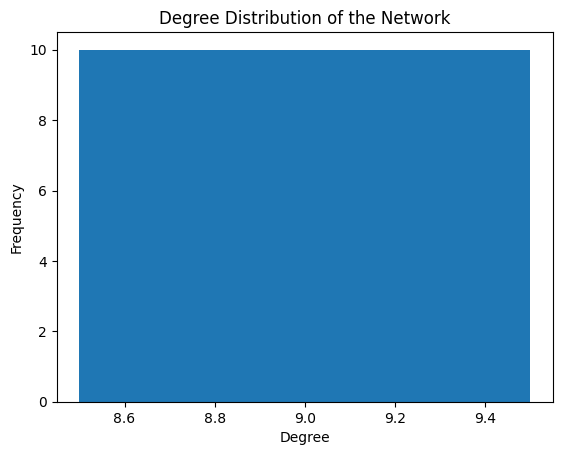

In [7]:
# Plot the degree distribution 
def plot_degree_distribution(G):
    """Calculate and plot the degree distribution of a network.
    
    Args:
        G: NetworkX Graph object
        
    Returns:
        list: List of degrees for all nodes
    """
    # Step 1: Calculate the degree of each node in the network
    # The degree of a node is simply the number of neighbors it has
    # NetworkX provides G.degree() which returns a view of (node, degree) pairs
    
    # Extract just the degree values (not the node IDs)
    # We iterate through all nodes and get their degree
    degrees = [degree for node, degree in G.degree()]
    
    # Alternative approach (more explicit):
    # degrees = []
    # for node in G.nodes():
    #     degree = G.degree(node)  # Number of edges connected to this node
    #     degrees.append(degree)
    
    
    # Create the histogram of degrees
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left')
    
    # Set labels and title
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution of the Network')
    
    # Show the plot
    plt.show()
    return degrees

degrees = plot_degree_distribution(G)

# BEGIN TESTS
# @name("Degree Calculation")
# @description("Check that degrees are correctly calculated")
def test_degree_calculation():
    test_G = nx.Graph()
    test_G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2)])
    test_degrees = plot_degree_distribution(test_G)
    assert isinstance(test_degrees, list), "Should return a list of degrees"
    assert len(test_degrees) == 4, "Should have degree for each node"
    assert sorted(test_degrees) == [1, 2, 2, 3], "Degrees should match expected values"
test_degree_calculation()

# @name("Degree List Structure")
# @description("Check that all degrees are non-negative integers")
def test_degree_list_structure():
    test_G = create_random_network(50, 3)
    test_degrees = plot_degree_distribution(test_G)
    assert all(isinstance(d, int) for d in test_degrees), "All degrees should be integers"
    assert all(d >= 0 for d in test_degrees), "All degrees should be non-negative"
test_degree_list_structure()

# @name("Degree Count")
# @description("Check that we have one degree value per node")
def test_degree_count():
    test_G = nx.complete_graph(10)
    test_degrees = plot_degree_distribution(test_G)
    assert len(test_degrees) == test_G.number_of_nodes(), "Should have one degree per node"
    assert all(d == 9 for d in test_degrees), "Complete graph should have all nodes with degree n-1"
test_degree_count()
# END TESTS

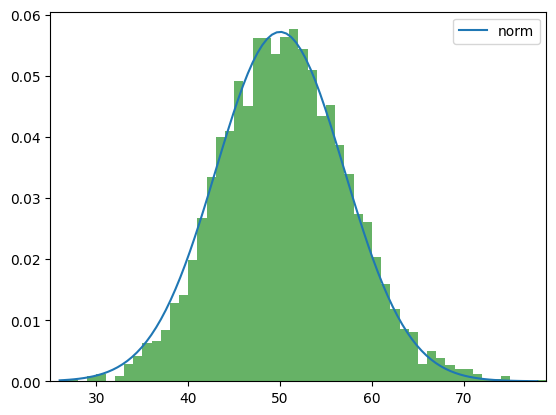

In [8]:
# Solution: we can fit a normal distribution to it.
# Sample data
data = [degree for node, degree in G.degree()]

# Plot histogram of the data
plt.hist(data, bins=range(min(data), max(data) + 2), density=True, alpha=0.6, color='g')

# List of candidate distributions
distributions = [stats.norm] 

# Fit distributions to the data and plot
for distribution in distributions:
    # Fit distribution to data
    params = distribution.fit(data)
    
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Calculate fitted PDF and error with fit in distribution
    pdf = distribution.pdf(np.linspace(min(data), max(data), 100), loc=loc, scale=scale, *arg)
    plt.plot(np.linspace(min(data), max(data), 100), pdf, label=f"{distribution.name}")
    plt.xlim([min(data) - 1, max(data) + 1])

plt.legend(loc='upper right')
plt.show()

### Model 2: Friends make friends through friends

The network we created, the nodes are connected randomly based on the nodes. But in most real-world networks, you make connections through your existing connections. For instance, the probability that you follow someone on Twitter depends on how many followers the person already has, since you are likely to encounter them through their followers.

These degree distributions are ubiquitous, and characterize nearly all networks around us, including link between websites, flights connecting airports, and so on.

In most social networks, nodes build connections based on their existing connections. This is called "preferential attachment".

#### Exercise 2C:
1. You will simulate the growth of a social media network. The network will have N nodes. These join one at the time. At each step, add one new node, then sample M existing nodes based on their edges, and add num_edges_per_node edges to these.
2. Plot the resulting degree distribution. What type of distribution is this? What does it mean that networks have this type of structure?


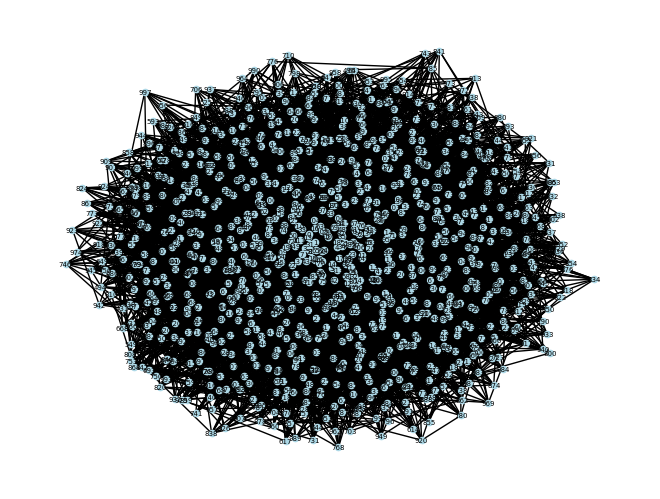

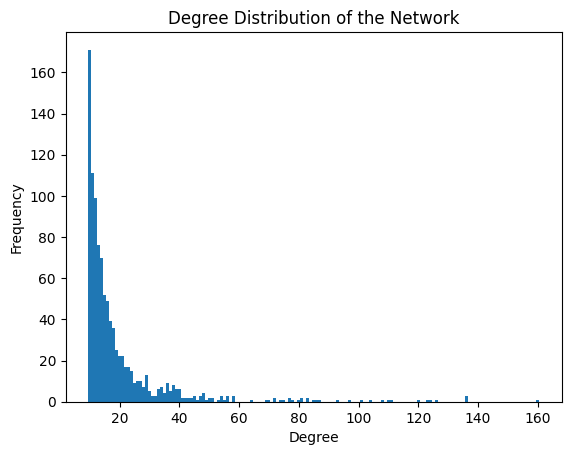

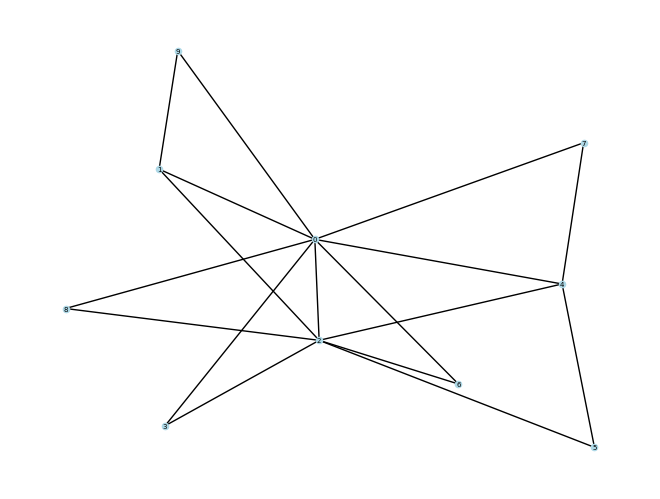

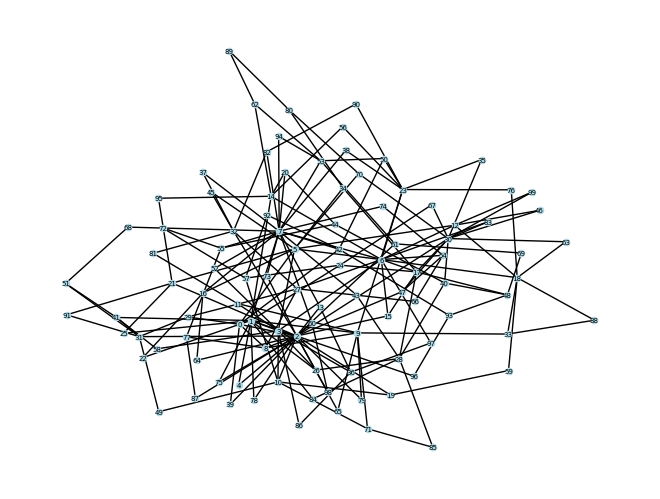

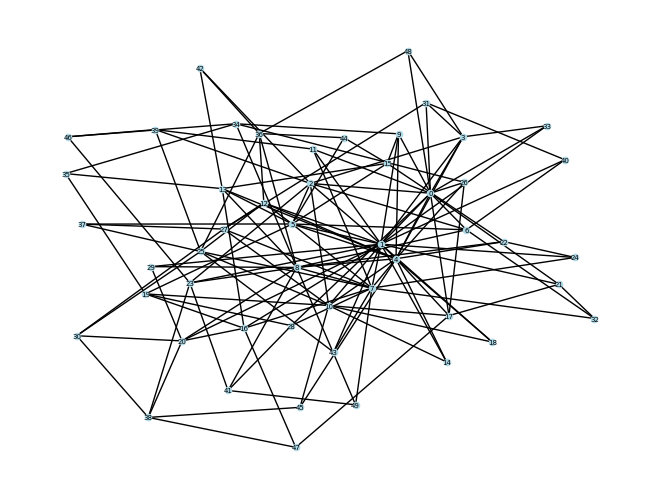

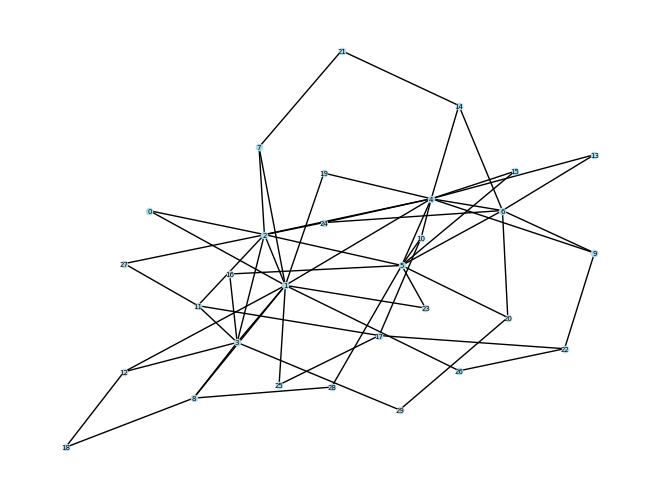

In [9]:
def create_random_network_by_edges(num_nodes, num_edges_per_node):
    """Create a scale-free network using preferential attachment.
    


    Args:
        num_nodes: Number of nodes in the network
        num_edges_per_node: Number of edges each new node creates
        
    Returns:
        NetworkX Graph object
    """
    # Step 1: Initialize the network with a small starting structure
    # We start with just 2 nodes connected by an edge
    # This gives us a base to build upon
    G = nx.Graph()
    G.add_node(0)
    G.add_node(1)
    G.add_edge(0, 1)
    
    # Step 2: Add nodes one by one using preferential attachment
    # This simulates how networks grow in real life (e.g., people joining a social network)
    for new_node_id in range(2, num_nodes):
        # Add the new node to the network
        G.add_node(new_node_id)
        
        # Step 3: Implement preferential attachment
        # The new node will connect to num_edges_per_node existing nodes
        # The probability of connecting to an existing node is proportional to its degree
        # This means popular nodes (with many connections) are more likely to get new connections
        
        # We need to sample existing nodes with probability proportional to their degree
        # One way to do this is to create a list where each node appears as many times
        # as its degree, then randomly sample from that list
        
        # Get all existing nodes (all nodes except the one we just added)
        existing_nodes = list(range(new_node_id))
        
        # Create a list for weighted random sampling
        # Each existing node appears in the list a number of times equal to its degree
        # This makes nodes with higher degree more likely to be selected
        weighted_node_list = []
        for node in existing_nodes:
            degree = G.degree(node)
            # Add this node to the list 'degree' times
            # If a node has degree 0, it won't be added (isolated nodes can't be selected)
            weighted_node_list.extend([node] * degree)
        
        # If no nodes have edges yet (shouldn't happen after initial setup), 
        # just connect to random nodes
        if len(weighted_node_list) == 0:
            # Fallback: connect to random existing nodes
            targets = random.sample(existing_nodes, min(num_edges_per_node, len(existing_nodes)))
        else:
            # Step 4: Sample nodes from the weighted list
            # We sample without replacement to avoid duplicate edges
            # If we need more connections than available nodes, we take all available
            num_connections = min(num_edges_per_node, len(weighted_node_list))
            selected_targets = random.sample(weighted_node_list, num_connections)
            
            # Remove duplicates (in case same node was selected multiple times)
            targets = list(set(selected_targets))
            
            # If we still need more connections (after removing duplicates),
            # add more random nodes from existing nodes
            while len(targets) < num_edges_per_node and len(targets) < len(existing_nodes):
                additional_target = random.choice(existing_nodes)
                if additional_target not in targets:
                    targets.append(additional_target)
        
        # Step 5: Add edges from the new node to the selected target nodes
        for target in targets:
            G.add_edge(new_node_id, target)
    
    
    # Draw the network
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=20, font_size=5)
    plt.show()
    return G

G = create_random_network_by_edges(1000, 10)
degrees = plot_degree_distribution(G)

# BEGIN TESTS
# @name("Network Initialization")
# @description("Check that the network starts with correct structure")
def test_network_initialization():
    test_G = create_random_network_by_edges(10, 2)
    assert test_G.number_of_nodes() == 10, "The function generates a network with incorrect number of nodes"
    assert test_G.number_of_edges() > 0, "The network should have edges"
test_network_initialization()

# @name("Preferential Attachment")
# @description("Check that preferential attachment creates scale-free properties")
def test_preferential_attachment():
    test_G = create_random_network_by_edges(100, 2)
    degrees = [degree for node, degree in test_G.degree()]
    # Scale-free networks should have some high-degree hubs
    max_degree = max(degrees)
    avg_degree = sum(degrees) / len(degrees)
    assert max_degree > avg_degree * 2, "Should have hub nodes with degree much higher than average"
test_preferential_attachment()

# @name("Edge Count")
# @description("Check that edges are added correctly")
def test_edge_count():
    test_G = create_random_network_by_edges(50, 3)
    # Starting with 1 edge, then adding 3 edges for nodes 2 through 49
    assert test_G.number_of_edges() >= 100, f"The function generates sufficient number of edges"
test_edge_count()

# @name("Connectivity")
# @description("Check that the network is connected")
def test_connectivity():
    test_G = create_random_network_by_edges(30, 2)
    assert nx.is_connected(test_G), "Preferential attachment network should be connected"
test_connectivity()
# END TESTS

(array([0.0002, 0.0002, 0.    , 0.0008, 0.0012, 0.    , 0.0008, 0.0028,
        0.0042, 0.0062, 0.0066, 0.0084, 0.0128, 0.0142, 0.0198, 0.0268,
        0.0334, 0.04  , 0.041 , 0.0492, 0.045 , 0.0562, 0.0562, 0.0536,
        0.0564, 0.0576, 0.0544, 0.051 , 0.0434, 0.0452, 0.0386, 0.034 ,
        0.0274, 0.026 , 0.0204, 0.016 , 0.0118, 0.0086, 0.008 , 0.0028,
        0.005 , 0.0038, 0.0026, 0.002 , 0.002 , 0.0012, 0.0004, 0.0004,
        0.0008, 0.0002, 0.0002, 0.    , 0.0002]),
 array([26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
        78., 79.]),
 <BarContainer object of 53 artists>)

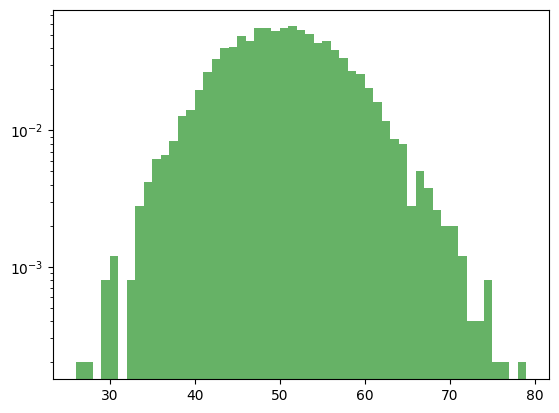

In [10]:
# It's straight on a log! 
plt.hist(data, bins=range(min(data), max(data) + 2), density=True, alpha=0.6, color='g', log=True)

Power law distribution: It's a scale-free network!

# 3. Epidemics in networks 

Networks also allow us to model dynamic phenomena, such as the spread of ideas, habits, or disease through networks. 

The structure of the network is central to how these spread. For instance, if Twitter changes how followingship is made, this will affect the dynamics of virality on Twitter.

The same accounts to disease spread. The SIR model is a classic framework used in epidemiology to understand how diseases spread through populations. SIR stands for Susceptible, Infected, and Recovered, which are the three possible states of individuals in this model:

- Susceptible (S): Individuals who have not yet contracted the disease and are vulnerable to infection.
- Infected (I): Individuals who have contracted the disease and are capable of spreading it to susceptible individuals.
- Recovered (R): Individuals who have recovered from the disease and are no longer susceptible to it. In some models, 'Recovered' can also include individuals who have died from the disease, as they are no longer part of the infection cycle.

We are now going to look at how the spread of the disease depends on the network structure. 

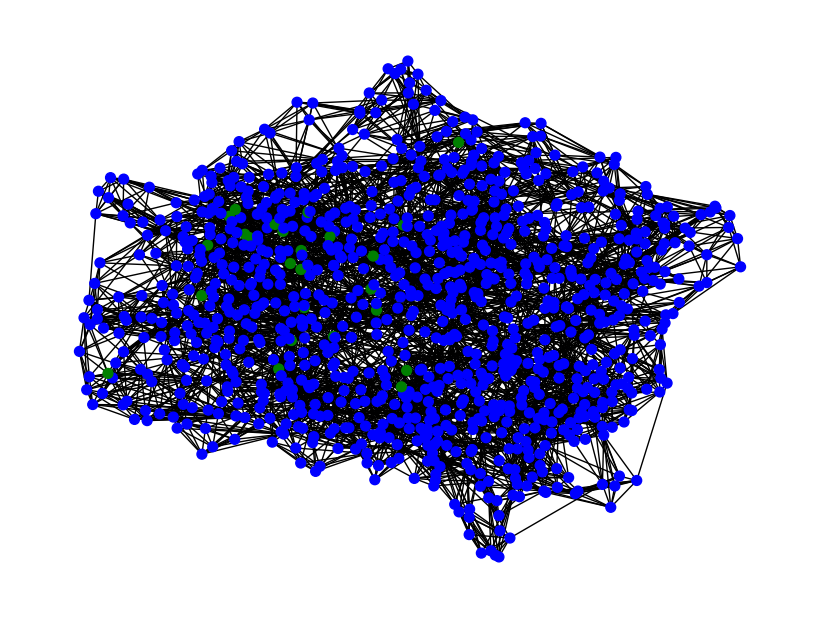

In [11]:
def SIR_simulation(G, initial_infected, infection_prob, recovery_prob):
    # Initialize all nodes as susceptible
    nx.set_node_attributes(G, 'S', 'state')

    # Infect initial nodes
    for node in initial_infected:
        G.nodes[node]['state'] = 'I'

    S, I, R = [], [], []
    # for _ in range(steps):
    while(True):
        new_infected = []
        new_recovered = []

        # Spread the infection
        for node in G:
            if G.nodes[node]['state'] == 'I':
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if G.nodes[neighbor]['state'] == 'S' and random.random() < infection_prob:
                        new_infected.append(neighbor)

                # Recover process
                if random.random() < recovery_prob:
                    new_recovered.append(node)

        # Update the states
        for node in new_infected:
            G.nodes[node]['state'] = 'I'
        for node in new_recovered:
            G.nodes[node]['state'] = 'R'

        S.append(sum(1 for n in G if G.nodes[n]['state'] == 'S'))
        nr_infected = sum(1 for n in G if G.nodes[n]['state'] == 'I')
        I.append(nr_infected)
        R.append(sum(1 for n in G if G.nodes[n]['state'] == 'R'))
        if nr_infected == 0:
            break

    return S, I, R

def plot_network(G):
    # Colors for nodes
    colors = ['blue' if G.nodes[node]['state'] == 'S' else ('red' if G.nodes[node]['state'] == 'I' else 'green') for node in G]

    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color=colors, node_size=50, with_labels=False)
    plt.show()

# Parameters for the SIR simulation
initial_infected_count = 5
infection_prob = 0.02 
recovery_prob = 0.1

# Create different network types
G = nx.watts_strogatz_graph(1000, 10, 0.1)    

# Example run!
initial_infected = random.sample(list(G.nodes()), initial_infected_count)
S, I, R = SIR_simulation(G, initial_infected, infection_prob, recovery_prob)
plot_network(G)


### Exercise 3:
Your task is to compare how well a disease spreads in different network structures. In which network does the disease spread fastest? In which networks does the disease spread to the most nodes?

In [12]:
# Networks to compare

# networks = {
#         "Scale-Free Network": nx.barabasi_albert_graph(1000, 2),
#         "Small-World Network": nx.watts_strogatz_graph(1000, 4, 0.1),
#         "Random Network": nx.erdos_renyi_graph(1000, 0.05),
#         "Network with Communities": nx.connected_caveman_graph(10, 100)
#     }

In [13]:
def run_sir_comparison(initial_infected_count=5, infection_prob=0.02, recovery_prob=0.1):
    """Run SIR simulations on different network types and compare spread dynamics.
    
    Args:
        initial_infected_count: Number of initially infected nodes
        infection_prob: Probability of infection spreading per contact
        recovery_prob: Probability of recovery per time step
        
    Returns:
        dict: Dictionary mapping network type to tuple of (S, I, R) time series
    """
    # Step 1: Initialize dictionary to store results for each network type
    # Each entry will contain the time series of S, I, R values
    results = {}
    
    # Step 2: Define the four network types we want to compare
    # Each network has 1000 nodes for fair comparison
    networks = {
        "Scale-Free Network": nx.barabasi_albert_graph(1000, 2),
        # Barabási-Albert: Preferential attachment, creates hub nodes
        # Parameter 2 means each new node connects to 2 existing nodes
        
        "Small-World Network": nx.watts_strogatz_graph(1000, 4, 0.1),
        # Watts-Strogatz: Starts as regular lattice, then randomizes some edges
        # Parameter 4: each node connected to 4 nearest neighbors initially
        # Parameter 0.1: 10% of edges are randomized
        
        "Random Network": nx.erdos_renyi_graph(1000, 0.05),
        # Erdős-Rényi: Completely random connections
        # Parameter 0.05: probability of edge between any two nodes is 5%
        
        "Network with Communities": nx.connected_caveman_graph(10, 100)
        # Connected Caveman: Creates 10 communities of 100 nodes each
        # Nodes are highly connected within communities, sparsely between
    }
    
    # Step 3: Run SIR simulation on each network type
    # We'll use the SIR_simulation function that was already defined earlier
    for network_name, network_graph in networks.items():
        # Create a copy of the network for this simulation
        # This is important because SIR_simulation modifies the graph (adds node attributes)
        G_copy = network_graph.copy()
        
        # Step 4: Randomly select initial infected nodes
        # We want to start with the same number of infected nodes for fair comparison
        all_nodes = list(G_copy.nodes())
        initial_infected = random.sample(all_nodes, min(initial_infected_count, len(all_nodes)))
        
        # Step 5: Run the SIR simulation
        # This will return three lists: S (susceptible count over time),
        # I (infected count over time), and R (recovered count over time)
        S, I, R = SIR_simulation(G_copy, initial_infected, infection_prob, recovery_prob)
        
        # Step 6: Store the results
        # We store as a tuple so we can easily unpack it later for analysis
        results[network_name] = (S, I, R)
    
    # Step 7: Return all results for comparison
    # The caller can then plot or analyze these time series to see differences
    
    
    return results

results = run_sir_comparison()

# BEGIN TESTS
# @name("Results Structure")
# @description("Check that results contain all network types")
def test_results_structure():
    test_results = run_sir_comparison(initial_infected_count=5, infection_prob=0.02, recovery_prob=0.1)
    assert isinstance(test_results, dict), "Results should be a dictionary"
    expected_networks = ["Scale-Free Network", "Small-World Network", "Random Network", "Network with Communities"]
    for net_type in expected_networks:
        assert net_type in test_results, f"Results should include {net_type}"
test_results_structure()

# @name("Time Series Data")
# @description("Check that each simulation returns valid time series")
def test_time_series_data():
    test_results = run_sir_comparison(initial_infected_count=5, infection_prob=0.02, recovery_prob=0.1)
    for net_type, (S, I, R) in test_results.items():
        assert isinstance(S, list), f"{net_type}: S should be a list"
        assert isinstance(I, list), f"{net_type}: I should be a list"
        assert isinstance(R, list), f"{net_type}: R should be a list"
        assert len(S) == len(I) == len(R), f"{net_type}: S, I, R should have same length"
        assert len(S) > 0, f"{net_type}: Time series should not be empty"
test_time_series_data()

# @name("Conservation of Population")
# @description("Check that S + I + R = total population at each time step")
def test_conservation_of_population():
    test_results = run_sir_comparison(initial_infected_count=5, infection_prob=0.02, recovery_prob=0.1)
    for net_type, (S, I, R) in test_results.items():
        total_population = S[0] + I[0] + R[0]
        for i in range(len(S)):
            assert S[i] + I[i] + R[i] == total_population, f"{net_type}: Population should not change over time"
test_conservation_of_population()

# @name("Epidemic Dynamics")
# @description("Check that epidemic eventually ends (I reaches 0)")
def test_epidemic_dynamics():
    test_results = run_sir_comparison(initial_infected_count=5, infection_prob=0.02, recovery_prob=0.1)
    for net_type, (S, I, R) in test_results.items():
        assert I[-1] == 0, f"{net_type}: Epidemic should end with no infected individuals"
        assert R[-1] > 0, f"{net_type}: Some individuals should have recovered"
test_epidemic_dynamics()
# END TESTS

# 4. Cascading failures in electricity grids

Cascading failures in electricity grids refer to a process where a failure in one part of the grid triggers a chain of failures throughout the system, leading to a large-scale power outage or blackout. The cascade often begins with a single failure or fault in one component of the grid, such as a transmission line, transformer, or generator. When a component fails, the electrical load it was carrying is redistributed to other parts of the grid. If this redistribution results in an excessive load on these components, they can also fail. Each subsequent failure puts additional strain on the system, causing more components to fail. This can create a domino effect, leading to widespread disconnections and outages.

You are a terrorist and you want to attack the US electricity grid. You have acquired the network of nodes, and you want to find how you can do the most damage.


In [14]:
G = nx.read_gml('sem3_topic5_sna_formative2_data.gml', label=None)

In [15]:
#The capacity of the nodes is proportional to their betweenness centrality
pagerank = nx.pagerank(G)
    
# Set node attribute
for node in G.nodes():
    G.nodes[node]['load'] = pagerank[node] * random.uniform(10000, 20000)
    G.nodes[node]['capacity'] = G.nodes[node]['load'] * random.uniform(1.3, 1.6)

In [16]:
nx.write_gexf(G,"sem3_topic5_sna_formative2_data.gexf")

In [17]:
G = nx.read_gexf('sem3_topic5_sna_formative2_data.gexf')

In [18]:
def initialize_grid():
    # Create a random graph to simulate a grid
    G = nx.read_gexf('sem3_topic5_sna_formative2_data.gexf')
    
    return G

# Reset the grid to unfailed status
def reset_grid(G):
    for node in G.nodes:
        G.nodes[node]['current_load'] = G.nodes[node]['load']
        G.nodes[node]['current_capacity'] = G.nodes[node]['capacity']
        G.nodes[node]['failed'] = False

# Fail a particular node
def fail_node(G, neighbors_dict, node):
    # Fail a node and redistribute its load
    load_to_redistribute = G.nodes[node]['current_load']
    G.nodes[node]['current_load'] = 0
    G.nodes[node]['failed'] = True
    neighbors = neighbors_dict[node]
    load_distribution = load_to_redistribute / len(neighbors)
    for neighbor in neighbors:
        G.nodes[neighbor]['current_load'] += load_distribution

# This code cascades the failure througout the network
def cascade_failure(G, neighbors_dict):
    failed = 0
    overloaded = True
    while overloaded:
        overloaded = False
        for node in list(G.nodes):
            if not G.nodes[node]['failed'] and G.nodes[node]['current_load'] > G.nodes[node]['current_capacity']:
                failed += 1
                fail_node(G, neighbors_dict, node)
                overloaded = True
    return failed

#Load graph 
G = initialize_grid()
# Precompute neighbor lists for speed
neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}

reset_grid(G)

# Simulate initial failure
initial_failure = random.choice(list(G.nodes))
fail_node(G, neighbors_dict, initial_failure)

# Simulate cascading failure
failed_nodes = cascade_failure(G,neighbors_dict)
print(f"The cascade brought down {failed_nodes} nodes.")


The cascade brought down 7 nodes.


### Exercise 4A
Your task is to examine: 

1. What is the distribution of collapses when the node is selected at random?

2. Which node results in the largest cascade? How many nodes are brought down when this is attacked?

In [19]:
def analyze_random_cascade_distribution(num_simulations=50):
    """Analyze the distribution of cascade failures when initial failure is random.
    
    Args:
        num_simulations: Number of random simulations to run
        
    Returns:
        list: List of failure counts for each simulation
    """
    # Step 1: Load the power grid network
    # This network represents the structure of the electricity grid
    G = initialize_grid()
    
    # Step 2: Precompute neighbor lists for efficiency
    # This avoids repeatedly calling G.neighbors() during the cascade
    # We create a dictionary mapping each node to its list of neighbors
    neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}
    
    # Step 3: Initialize list to store cascade outcomes
    # Each outcome is the total number of nodes that failed in that simulation
    outcomes = []
    
    # Step 4: Run multiple simulations with different random starting points
    # This gives us a distribution of possible cascade sizes
    for simulation in range(num_simulations):
        # Step 5: Reset the grid to its initial state for each simulation
        # This ensures each simulation starts with the same grid configuration
        # (all nodes have their original load and capacity, none have failed)
        reset_grid(G)
        
        # Step 6: Randomly select a node to fail initially
        # This simulates a random failure event (e.g., equipment malfunction, attack)
        all_nodes = list(G.nodes)
        initial_failure_node = random.choice(all_nodes)
        
        # Step 7: Trigger the initial failure
        # This redistributes the failed node's load to its neighbors
        fail_node(G, neighbors_dict, initial_failure_node)
        
        # Step 8: Run the cascade simulation
        # This function continues the cascade until no more nodes fail
        # It returns the number of additional nodes that failed (excluding the initial one)
        additional_failures = cascade_failure(G, neighbors_dict)
        
        # Step 9: Calculate total failures (initial + cascading)
        # The initial failure counts as 1, plus all the cascading failures
        total_failures = 1 + additional_failures
        
        # Step 10: Store the outcome
        outcomes.append(total_failures)
    
    # Step 11: Return all outcomes
    # This list can be used to create a histogram showing the distribution
    # of cascade sizes, calculate statistics (mean, median, max), etc.
    
    
    return outcomes

outcomes = analyze_random_cascade_distribution()

# BEGIN TESTS
# @name("Simulation Count")
# @description("Check that correct number of simulations are run")
def test_simulation_count():
    test_outcomes = analyze_random_cascade_distribution(num_simulations=10)
    assert len(test_outcomes) == 10, "Should run exactly 10 simulations"
    assert all(isinstance(x, int) for x in test_outcomes), "All outcomes should be integers"
test_simulation_count()

# @name("Cascade Values")
# @description("Check that cascade values are non-negative")
def test_cascade_values():
    test_outcomes = analyze_random_cascade_distribution(num_simulations=20)
    assert all(x >= 0 for x in test_outcomes), "All cascade counts should be non-negative"
test_cascade_values()

# @name("Variability")
# @description("Check that different simulations produce varied results")
def test_variability():
    test_outcomes = analyze_random_cascade_distribution(num_simulations=30)
    # With random selection, we should see some variability
    # (not all outcomes identical unless network is trivial)
    assert len(set(test_outcomes)) > 1 or len(test_outcomes) < 5, "Should see some variability in cascade sizes"
test_variability()
# END TESTS

### Exercise 4B

In [20]:
def find_worst_cascade_node():
    """Find which node causes the largest cascade when it fails.
    
    Returns:
        tuple: (worst_node, max_failures, outcomes_dict) where worst_node is the node ID,
               max_failures is the number of cascading failures, and outcomes_dict maps
               all nodes to their cascade counts
    """
    # Step 1: Load the power grid network
    # This is the network structure we'll be testing
    G = initialize_grid()
    
    # Step 2: Precompute neighbor lists for efficiency
    # This speeds up the cascade simulation by avoiding repeated neighbor lookups
    neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}
    
    # Step 3: Initialize dictionary to store cascade outcomes
    # Key: node ID, Value: total number of nodes that fail when this node fails
    outcomes = {}
    
    # Step 4: Test each node in the network
    # We systematically fail each node and measure the resulting cascade
    for node_to_test in G.nodes():
        # Step 5: Reset the grid to initial state for this test
        # Each test must start with the same grid configuration
        reset_grid(G)
        
        # Step 6: Fail the node we're testing
        # This triggers the initial failure and redistributes its load
        fail_node(G, neighbors_dict, node_to_test)
        
        # Step 7: Run the cascade simulation
        # This continues the cascade until no more nodes fail
        # It returns the number of additional nodes that failed (cascading failures)
        additional_failures = cascade_failure(G, neighbors_dict)
        
        # Step 8: Calculate total failures for this node
        # Total = 1 (the initial failure) + all cascading failures
        total_failures = 1 + additional_failures
        
        # Step 9: Store the result for this node
        outcomes[node_to_test] = total_failures
    
    
    # Find the worst node
    sorted_outcomes = dict(sorted(outcomes.items(), key=lambda item: -item[1]))
    worst_node, max_failures = list(sorted_outcomes.items())[0]
    
    return worst_node, max_failures, outcomes

worst_node, max_failures, outcomes = find_worst_cascade_node()
print(f"Node {worst_node} causes the worst cascade with {max_failures} failures")

# BEGIN TESTS
# @name("All Nodes Tested")
# @description("Check that all nodes in the network are tested")
test_worst_node, test_max_failures, test_outcomes = find_worst_cascade_node()
def test_all_nodes_tested():
    G = initialize_grid()
    assert len(test_outcomes) == len(G.nodes()), "Should test all nodes in the network"
    assert set(test_outcomes.keys()) == set(G.nodes()), "Should have results for all nodes"
test_all_nodes_tested()

# @name("Worst Node Identification")
# @description("Check that worst node is correctly identified")
def test_worst_node_identification():
    assert test_worst_node in test_outcomes, "Worst node should be in outcomes"
    assert test_outcomes[test_worst_node] == test_max_failures, "Worst node should have max failures"
    assert test_max_failures == max(test_outcomes.values()), "Max failures should be the maximum value"
test_worst_node_identification()

# @name("Failure Counts")
# @description("Check that all failure counts are non-negative")
def test_failure_counts():
    assert all(v >= 0 for v in test_outcomes.values()), "All failure counts should be non-negative"
    assert test_max_failures >= 0, "Max failures should be non-negative"
test_failure_counts()

# @name("Results Consistency")
# @description("Check that outcomes dictionary has correct structure")
def test_results_consistency():
    assert isinstance(test_outcomes, dict), "Outcomes should be a dictionary"
    assert all(isinstance(v, int) for v in test_outcomes.values()), "All cascade counts should be integers"
test_results_consistency()
# END TESTS

Node 1361 causes the worst cascade with 639 failures


In [21]:
sorted_dict = dict(sorted(outcomes.items(), key=lambda item: -item[1]))

print(list(sorted_dict.items())[0])


('1361', 639)


In [22]:
print(f"The mean station leads to {np.mean(list(outcomes.values()))} crashes.")
print(f"The median station leads to {np.median(list(outcomes.values()))} crashes.")
print(f"The max station leads to {max(list(outcomes.values()))} crashes.")

The mean station leads to 8.214733859542603 crashes.
The median station leads to 2.0 crashes.
The max station leads to 639 crashes.
